# Bayesian Randomized Benchmarking  Demo

This is a bayesian pyMC3 implementation on top of frequentist interleaved RB from qiskit experiments

Based on this [WIP tutorial](https://github.com/Qiskit/qiskit-experiments/blob/main/docs/tutorials/rb_example.ipynb) 
on july 10 2021


In [1]:
import numpy as np
import copy
import qiskit_experiments as qe
import qiskit.circuit.library as circuits
rb = qe.randomized_benchmarking

# for retrieving gate calibration
from datetime import datetime
import qiskit.providers.aer.noise.device as dv

# import the bayesian packages
import pymc3 as pm
import arviz as az
import bayesian_fitter as bf

In [2]:
simulation = True # make your choice here
if simulation:
    from qiskit.providers.aer import AerSimulator
    from qiskit.test.mock import FakeParis
    backend = AerSimulator.from_backend(FakeParis())
else:
    from qiskit import IBMQ
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = provider.get_backend('ibmq_lima') # type here hardware backend  

In [27]:
import importlib
importlib.reload(bf)

<module 'bayesian_fitter' from 'C:\\Users\\decpi\\OneDrive\\Documents\\qiskit-tutorials-master\\tutorials\\noise\\bayesian_fitter.py'>

# Running 1-qubit RB

---------------------------------------------------
Experiment: StandardRB
Experiment ID: 3051d86c-2fd3-4559-a767-3310080b487b
Status: DONE
Circuits: 100
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.47740811449053433 ± 0.010108659378860563
- alpha: 0.9957298638759341 ± 0.0003428385567477714
- b: 0.5058163655018323 ± 0.00971472975879595
- analysis_type: RBAnalysis
- reduced_chisq: 0.09368628885182677
- dof: 7
- xrange: [1.0, 901.0]
- EPC: 0.002135068062032952
- EPC_err: 0.00017215440110094376
- EPG: {0: {'rz': 0.0, 'sx': 0.0004322490834099537, 'x': 0.0004322490834099537}}
- success: True


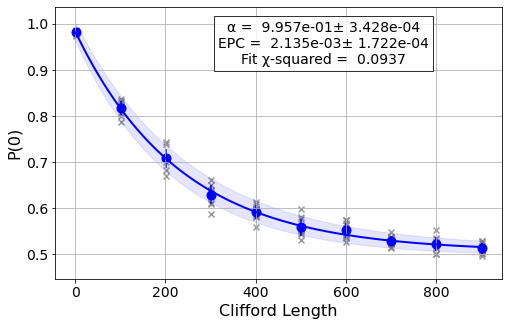

In [28]:
lengths = np.arange(1, 1000, 100)
num_samples = 10
seed = 1010
qubits = [0]
# Run an RB experiment on qubit 0
exp1 = rb.StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)
expdata1 = exp1.run(backend)

# View result data
print(expdata1)

In [29]:
physical_qubits = [0]
nQ = len(qubits)
scale = (2 ** nQ - 1) / 2 ** nQ
interleaved_gate =''

In [30]:
# retrieve from the frequentist model (fm) analysis
# some values,including priors, for the bayesian analysis
perr_fm, popt_fm, epc_est_fm, epc_est_fm_err, experiment_type = bf.retrieve_from_lsf(expdata1)
EPG_dic = expdata1._analysis_results[0]['EPG'][qubits[0]]
# get count data
Y = bf.get_GSP_counts(expdata1._data, len(lengths),range(num_samples))
shots = bf.guess_shots(Y)

### Pooled model

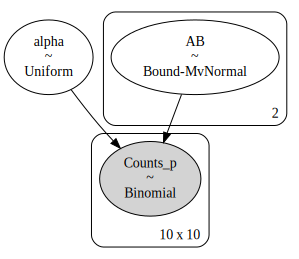

In [31]:
#build model
pooled_model = bf.get_bayesian_model(model_type="pooled",Y=Y,shots=shots,m_gates=lengths,
                                           mu_AB=[popt_fm[0],popt_fm[2]],cov_AB=[perr_fm[0],perr_fm[2]],
                                           alpha_ref=popt_fm[1],
                                           alpha_lower=popt_fm[1]-6*perr_fm[1],
                                           alpha_upper=min(1.-1.E-6,popt_fm[1]+6*perr_fm[1]))
pm.model_to_graphviz(pooled_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 116 seconds.
The number of effective samples is smaller than 25% for some parameters.


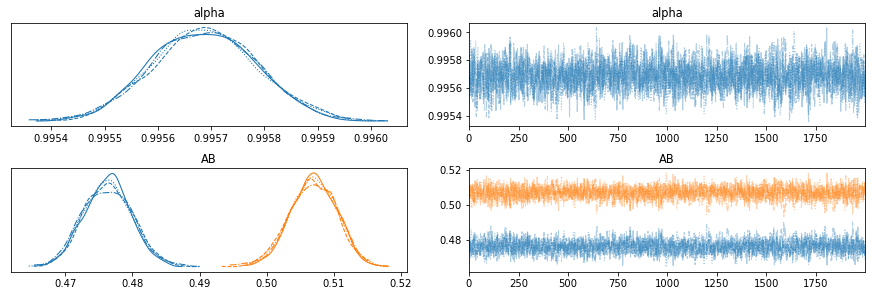

In [32]:
trace_p = bf.get_trace(pooled_model, target_accept = 0.95)

In [33]:
# backend's recorded EPG
print(rb.RBUtils.get_error_dict_from_backend(backend, qubits))

{((0,), 'id'): 0.0004432101747785104, ((0,), 'rz'): 0, ((0,), 'sx'): 0.0004432101747785104, ((0,), 'x'): 0.0004432101747785104}


           mean        sd    hdi_3%   hdi_97%
alpha  0.995688  0.000099  0.995500  0.995870
AB[0]  0.476342  0.003614  0.469744  0.483336
AB[1]  0.506909  0.003476  0.500081  0.513033 

Model:    Frequentist        Bayesian
_______________________________________
EPC         2.135e-03        2.156e-03 
± sigma    ± 1.722e-04      ± 4.950e-05 
EPG rz      0.000e+00        0.000e+00
EPG sx      4.322e-04        4.365e-04
EPG x       4.322e-04        4.365e-04


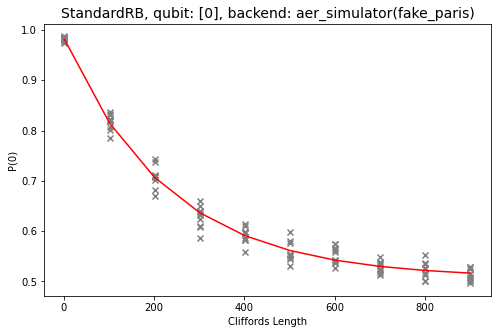

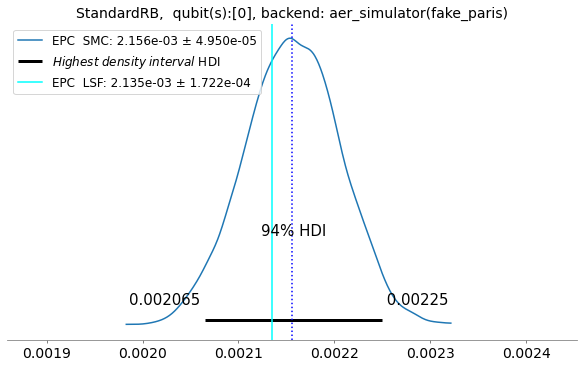

In [34]:
bf.RB_bayesian_results(pooled_model, trace_p, lengths,
                       epc_est_fm, epc_est_fm_err, experiment_type, scale,                       
                       num_samples, Y, shots, physical_qubits, interleaved_gate, backend,
                       EPG_dic = EPG_dic)

### Hierarchical model

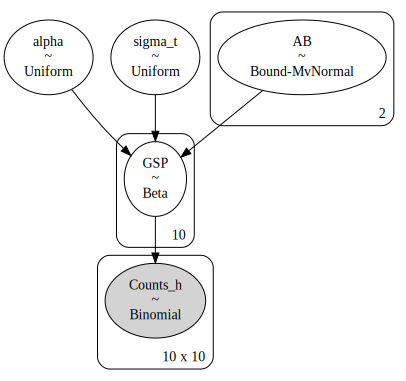

In [35]:
#build model
original_model = bf.get_bayesian_model(model_type="h_sigma",Y=Y,shots=shots,m_gates=lengths,
                                           mu_AB=[popt_fm[0],popt_fm[2]],cov_AB=[perr_fm[0],perr_fm[2]],
                                           alpha_ref=popt_fm[1],
                                           alpha_lower=popt_fm[1]-6*perr_fm[1],
                                           alpha_upper=min(1.-1.E-6,popt_fm[1]+6*perr_fm[1]),
                                           sigma_theta=0.001,sigma_theta_l=0.0005,sigma_theta_u=0.0015)
pm.model_to_graphviz(original_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [GSP, sigma_t, AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 396 seconds.
The number of effective samples is smaller than 25% for some parameters.


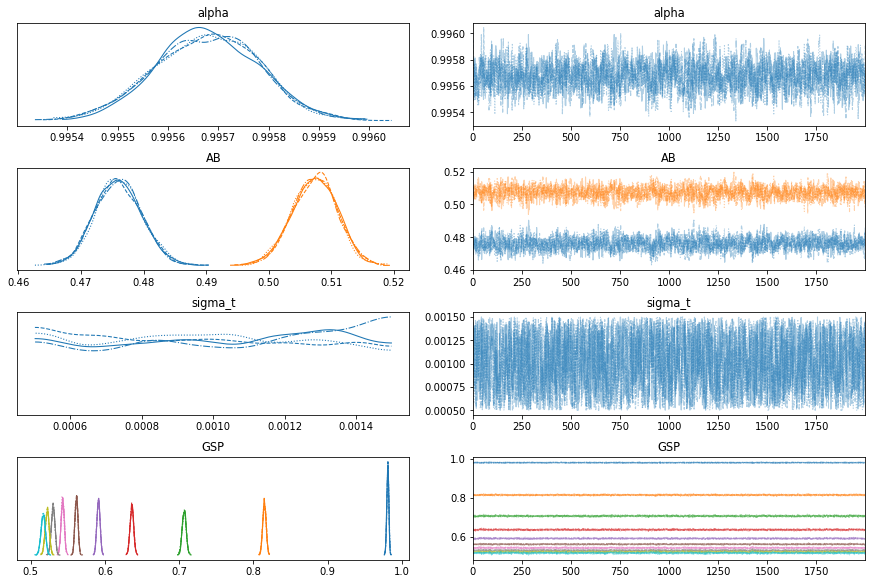

In [36]:
trace_o = bf.get_trace(original_model, target_accept = 0.95)

In [37]:
# backend's recorded EPG
print(rb.RBUtils.get_error_dict_from_backend(backend, qubits))

{((0,), 'id'): 0.0004432101747785104, ((0,), 'rz'): 0, ((0,), 'sx'): 0.0004432101747785104, ((0,), 'x'): 0.0004432101747785104}


             mean        sd    hdi_3%   hdi_97%
alpha    0.995677  0.000103  0.995476  0.995860
AB[0]    0.476004  0.003727  0.469408  0.483239
AB[1]    0.507318  0.003578  0.500497  0.513866
sigma_t  0.001005  0.000290  0.000500  0.001439
GSP[0]   0.981185  0.001334  0.978472  0.983521
GSP[1]   0.814874  0.002270  0.810739  0.819283
GSP[2]   0.706736  0.002638  0.701747  0.711649
GSP[3]   0.636268  0.002425  0.631594  0.640623
GSP[4]   0.591258  0.002131  0.587351  0.595196
GSP[5]   0.561619  0.002015  0.557831  0.565306
GSP[6]   0.543046  0.002158  0.538801  0.546921
GSP[7]   0.530202  0.002393  0.525753  0.534719
GSP[8]   0.522240  0.002650  0.517287  0.527240
GSP[9]   0.516811  0.002883  0.511258  0.522020 

Model:    Frequentist        Bayesian
_______________________________________
EPC         2.135e-03        2.161e-03 
± sigma    ± 1.722e-04      ± 5.150e-05 
EPG rz      0.000e+00        0.000e+00
EPG sx      4.322e-04        4.376e-04
EPG x       4.322e-04        4.376e-04


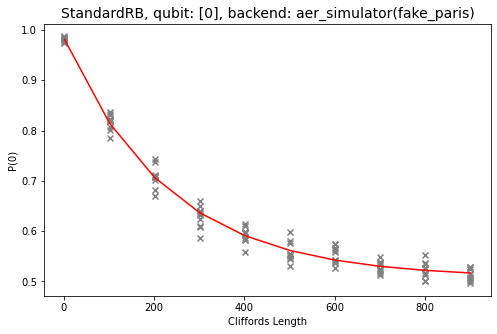

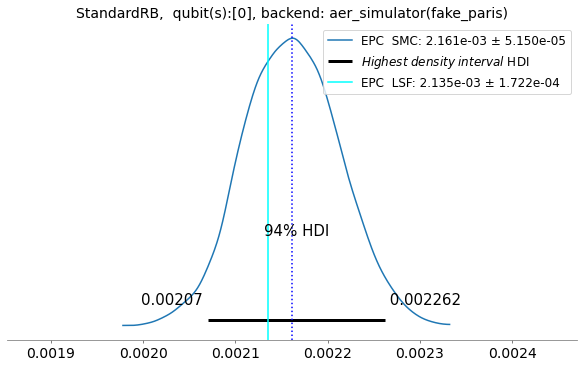

In [38]:
bf.RB_bayesian_results(original_model, trace_o, lengths,
                       epc_est_fm, epc_est_fm_err, experiment_type, scale,                       
                       num_samples, Y, shots, physical_qubits, interleaved_gate, backend,
                       EPG_dic = EPG_dic)